In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


# 0. Importing Libraries

In [2]:
#Main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Utilities
import random
import re
import pickle
from tqdm.auto import tqdm


#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve
from sklearn.metrics import RocCurveDisplay


#torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

#Hugging Face
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import set_seed
from transformers import get_linear_schedule_with_warmup


#### Random States:

In [3]:
# Python and Numpy
seed = 42
random.seed(seed)
np.random.seed(seed)

# Save states (optional, for later restoration)
python_state = random.getstate()
numpy_state = np.random.get_state()

In [4]:
# torch 
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU
torch.backends.cudnn.deterministic = True  # Slower but reproducible
torch.backends.cudnn.benchmark = False

# Save RNG states
torch_rng_state = torch.get_rng_state()
cuda_rng_state = torch.cuda.get_rng_state() if torch.cuda.is_available() else None

In [5]:
#Hugging Face
set_seed(seed)

In [6]:
#Saving all random states

random_states = {
    "python": random.getstate(),
    "numpy": np.random.get_state(),
    "torch_cpu": torch.get_rng_state(),
    "torch_cuda": torch.cuda.get_rng_state() if torch.cuda.is_available() else None,
    "sklearn_seed": seed  # For train_test_split
}

# Save to file
with open("random_states.pkl", "wb") as f:
    pickle.dump(random_states, f)

# 1. Load and Preprocess the Data:

In [34]:
df_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')[:500]
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')[:500]
df_test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')

In [35]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [9]:
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
495,00cf862de0929a0d,vivek is a bad boy \n\n > B.Tech graduate
496,00cf8932eb2dcdcc,== hmong people only == \n\n i rock for b...
497,00cfd946fcc6f8ed,someone keeps editing this page and changing t...
498,00d06c6557280d2f,P.S. I've never seen birth and death dates for...


In [10]:
df_train.loc[df_train['toxic'] == 1, ['comment_text']].iloc[0]

comment_text    COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Name: 6, dtype: object

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [12]:
df_train['comment_text'] = df_train['comment_text'].map(lambda com : clean_text(com))
df_test['comment_text'] = df_test['comment_text'].map(lambda com : clean_text(com))

In [13]:
comments = df_train["comment_text"].tolist()
labels = df_train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

# Split data (80% train, 20% validation)
train_comments, val_comments, train_labels, val_labels = train_test_split(
    comments, labels, test_size=0.2, random_state=seed
)

# 2. Tokenization:

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Changed to BERT

def tokenize(texts):
    return tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors="pt"
    )

# Tokenize data (works exactly the same way)
train_encodings = tokenize(train_comments)
val_encodings = tokenize(val_comments)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 3. PyTorch Dataset:

In [15]:
class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.FloatTensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 4. BERT Model:

### a. Load Pre-trained Roberta Model:

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
).to("cuda" if torch.cuda.is_available() else "cpu")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### b. Training Loop

In [17]:
# Hyperparameters
epochs = 1
lr = 2e-5
warmup_steps = 100
max_grad_norm = 1.0

# Training Setup - Using torch.optim.AdamW
optimizer = AdamW(model.parameters(), lr=lr)

# Learning rate schedule (reimplementing warmup)
def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda)

# Tracking
best_metrics = {
    'val_loss': float('inf'),
    'weights': None
}
history = []

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(model.device)
        
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate
        
        train_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_train_loss = train_loss / len(train_loader)

    # --- Validation Phase ---
    avg_val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(model.device)  # Keep labels on device
            
            # Pass labels to compute validation loss
            outputs = model(**inputs, labels=labels)
            avg_val_loss += outputs.loss.item()

    avg_val_loss /= len(val_loader)

    # --- Progress Tracking ---
    history.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    })
    
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # --- Model Checkpointing ---
    if avg_val_loss < best_metrics['val_loss']:
        best_metrics.update({
            'val_loss': avg_val_loss,
            'weights': model.state_dict().copy()
        })
        torch.save(best_metrics['weights'], "best_model.pt")
        print("↳ New best model saved!")

# Final save
if not os.path.exists("best_model.pt"):
    torch.save(model.state_dict(), "final_model.pt")


Epoch 1/1 [Train]:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 1 Results:
Train Loss: 0.6930 | Val Loss: 0.6358
↳ New best model saved!


# 5. Model Evaluation:

### a. Calculating Metrics

In [33]:
model.eval()  # Set model to evaluation mode
val_preds = []
val_true = []

with torch.no_grad():
    for batch in val_loader:  # Use validation DataLoader
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].cpu().numpy()
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()
        val_preds.extend(probs)
        val_true.extend(labels)

val_preds = np.array(val_preds)
val_true = np.array(val_true)


# Classification Report (threshold to be controlled)
print(classification_report(
    val_true, 
    val_preds > 0.4,  # Binary predictions
    target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
))

               precision    recall  f1-score   support

        toxic       0.12      1.00      0.21        12
 severe_toxic       0.01      1.00      0.02         1
      obscene       0.06      1.00      0.11         6
       threat       0.01      1.00      0.02         1
       insult       0.07      1.00      0.13         7
identity_hate       0.01      1.00      0.02         1

    micro avg       0.05      1.00      0.09        28
    macro avg       0.05      1.00      0.09        28
 weighted avg       0.08      1.00      0.15        28
  samples avg       0.05      0.12      0.07        28



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### b. Visualizing:

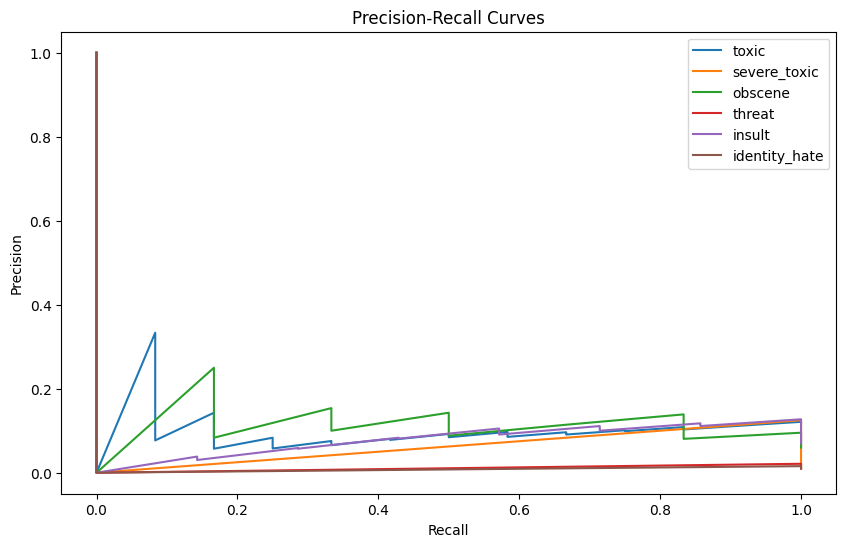

In [27]:
plt.figure(figsize=(10, 6))
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    precision, recall, _ = precision_recall_curve(val_true[:, i], val_preds[:, i])
    plt.plot(recall, precision, label=label)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curves")
plt.show()

### c. Finding Optimal Threshold:

In [28]:
optimal_thresholds = []
for i in range(6):
    precision, recall, thresholds = precision_recall_curve(val_true[:, i], val_preds[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_thresholds.append(thresholds[np.argmax(f1_scores)])
print(f"Optimal Thresholds: {optimal_thresholds}")

Optimal Thresholds: [0.45286965, 0.50945526, 0.46039537, 0.43875405, 0.48464993, 0.42340577]


# 6. Making Predictions:

In [21]:
# Initialize BERT model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Changed to BERT
    num_labels=6,
    problem_type="multi_label_classification"
)

# Load weights (automatically falls back to final_model.pt if best doesn't exist)
model_path = "best_model.pt" if os.path.exists("best_model.pt") else "final_model.pt"
model.load_state_dict(torch.load(model_path))
model.to("cuda" if torch.cuda.is_available() else "cpu")

# BERT tokenizer (different from RoBERTa)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Changed to BERT

# Tokenize test data (BERT handles special tokens automatically)
inputs = tokenizer(
    df_test["comment_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Get probabilities
with torch.no_grad():
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).cpu().numpy()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-4a465eb4168c>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

In [22]:
# Define your class names (must match training order)
toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Add probability columns
for i, col in enumerate(toxicity_classes):
    df_test[f"{col}_prob"] = probs[:, i]
    
# Add binary predictions (threshold=0.5)
for col in toxicity_classes:
    df_test[f"{col}_pred"] = (df_test[f"{col}_prob"] > 0.5).astype(int)

In [23]:
df_test.head()

,id,comment_text,toxic_prob,severe_toxic_prob,obscene_prob,threat_prob,insult_prob,identity_hate_prob,toxic_pred,severe_toxic_pred,obscene_pred,threat_pred,insult_pred,identity_hate_pred
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...,0.491549,0.465457,0.436462,0.423912,0.467103,0.509170,0,0,0,0,0,1
1,0000247867823ef7,from rfc the title is fine as it is imo,0.457742,0.506755,0.463435,0.441780,0.507090,0.430423,0,1,0,0,1,0
2,00013b17ad220c46,sources zawe ashton on lapland,0.459846,0.488447,0.468667,0.463013,0.518716,0.401502,0,0,0,0,1,0
3,00017563c3f7919a,if you have a look back at the source the info...,0.490473,0.479087,0.449693,0.419337,0.472103,0.507946,0,0,0,0,0,1
4,00017695ad8997eb,i do not anonymously edit articles at all,0.462573,0.510695,0.463550,0.456709,0.502350,0.405275,0,1,0,0,1,0


# 1000. Try

#### Single Sentence Prediction:

In [24]:
# Load your trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.load_state_dict(torch.load("best_model.pt"))  # or "final_model.pt"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# Your input sentence
sentence = "This is a toxic comment that should be flagged"

# Tokenize and predict
inputs = tokenizer(sentence, 
                 padding=True, 
                 truncation=True, 
                 max_length=128, 
                 return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]  # Get probabilities

# Define your class names (same order as training)
toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Print results
print("Predicted probabilities:")
for cls, prob in zip(toxicity_classes, probs):
    print(f"{cls}: {prob:.4f}")

# Get binary predictions (threshold=0.5)
binary_preds = (probs > 0.5).astype(int)
print("\nBinary predictions (threshold=0.5):")
for cls, pred in zip(toxicity_classes, binary_preds):
    print(f"{cls}: {'✅' if pred else '❌'}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-24-6484027c5ef6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

Predicted probabilities:
toxic: 0.4606
severe_toxic: 0.5102
obscene: 0.4566
threat: 0.4350
insult: 0.4989
identity_hate: 0.4309

Binary predictions (threshold=0.5):
toxic: ❌
severe_toxic: ✅
obscene: ❌
threat: ❌
insult: ❌
identity_hate: ❌


#### Multi-Sentence Prediction:

In [25]:
sentences = [
    "You're stupid!",
    "Thanks for your help",
    "Go back to your country"
]

# Tokenize batch
inputs = tokenizer(sentences, 
                 padding=True, 
                 truncation=True, 
                 max_length=128, 
                 return_tensors="pt").to(device)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    all_probs = torch.sigmoid(outputs.logits).cpu().numpy()

# Display results
for i, sentence in enumerate(sentences):
    print(f"\nSentence: '{sentence}'")
    for cls, prob in zip(toxicity_classes, all_probs[i]):
        print(f"{cls}: {prob:.4f}")


Sentence: 'You're stupid!'
toxic: 0.4806
severe_toxic: 0.4888
obscene: 0.4729
threat: 0.4728
insult: 0.4951
identity_hate: 0.3855

Sentence: 'Thanks for your help'
toxic: 0.4889
severe_toxic: 0.4888
obscene: 0.4587
threat: 0.4253
insult: 0.4742
identity_hate: 0.4885

Sentence: 'Go back to your country'
toxic: 0.4900
severe_toxic: 0.4846
obscene: 0.4633
threat: 0.5219
insult: 0.4924
identity_hate: 0.3553
